<a href="https://colab.research.google.com/github/fanzhenya/options_lab/blob/main/options_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poorman's Options Lab
---

## TL;DR

This notebook has three tools
1. find_best_put_to_sell
  - input a ticker and the max breakeven price, output the top cash covered put options to sell that yields highest Annualized Return Rate for the cash collateral. 
2. find_best_call_to_sell
  - input a ticker and the min breakeven price, output the top covered call options to sell that yields highest Annualized Return Rate for the equity collateral.
3. find_best_call_to_buy
  - input a ticker, visualize the Implied Volatility of call option over different expiration dates and strike prices. The dips in the curves are **probably** better choices to buy than their neighbors.

## Disclaimer

This software comes with absolutely no warranty nor support whatsoever, and it's purely for research purpose. Use it at your own risk.

## FAQ

1. How to use this notebook? 
  - Search "how to use ipython notebook". 
  - Run "Common Block" first, then run the individual tools block.
2. Where did you get the data? 
  - All the financial data used by this program are from yahoo finance. 
  - The data quality (accuracy, integrity, latency, etc.) is totally up to [finance.yahoo.com](https://finance.yahoo.com/) and the [yfinance](https://pypi.org/project/yfinance/) tool.


In [54]:
# Common Block

!pip install yfinance --upgrade --no-cache-dir

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import date
import yfinance as yf
import pandas as pd
from IPython.display import HTML

def get_days_to_expiracy(target: str):
  target = tuple(map(int, target.split('-')))
  # print(*ymd)
  today = date.today()
  target = date(*target)
  delta = target - today
  # print(today, target, delta)
  return delta.days + 1

# print(get_days_to_expiracy('2020-11-20'))

def annualize_return(return_to_principle: float, days: int) -> float:
    """Return the annualized return percentage given the holding return percentage and the number of months held.
    References:
        https://en.wikipedia.org/wiki/Holding_period_return
        https://www.wikihow.com/Calculate-Annualized-Portfolio-Return
        https://stackoverflow.com/a/52618808/
    """
    rate = 1 + return_to_principle
    years = days / 365
    anr = (rate**(1 / years)) - 1
    percent = anr * 100
    return percent

# print(annualize_return(0.38/30, 2))
# print(annualize_return(5.1/35, 30))
# print(annualize_return(0.01, 7))
# print(annualize_return(0.046, 7))
# print(annualize_return(0.061, 91))

def calc_put_anr(put, exp_date, trans_fee = 0.65/100):
  return_rate = (put.bid - trans_fee) / put.strike
  days = get_days_to_expiracy(exp_date)
  return annualize_return(return_rate, days)

def calc_put_breakeven(put):
  return put.strike - put.bid

def ticker_cur_price(ticker):
  return ticker.history().tail(1)['Close'].iloc[0]

def calc_call_anr(ticker_cur_price, call, exp_date, trans_fee = 0.65/100):
  return_rate = (call.bid - trans_fee) / ticker_cur_price
  days = get_days_to_expiracy(exp_date)
  return annualize_return(return_rate, days)

def calc_call_breakeven(call):
  return call.strike + call.bid


Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.55)


In [61]:
# Tool 1: find_best_put_to_sell

def find_best_put_to_sell(ticker_name, max_breakeven, min_volume = 10, min_last_price = 0.01, top_k = 10):
  """
  Input a ticker and the max breakeven price, output the top cash covered put options to sell that 
  yields highest Annualized Return Rate for the cash collateral.
  """
  ticker = yf.Ticker(ticker_name)
  print("ticker", ticker.info["symbol"])
  all_puts = pd.DataFrame()

  for exp_date in ticker.options:
    opts = ticker.option_chain(exp_date)
  
    puts = opts.puts
    
    puts['expDate'] = exp_date

    # filter by max breakeven
    puts['breakeven'] = puts.apply(calc_put_breakeven, axis=1)
    puts = puts[puts['breakeven'] < max_breakeven]

    # filter by volume
    puts = puts[puts['volume'] > min_volume]

    # filter garbage bid prices
    puts = puts[puts['bid'] > min_last_price]

    if puts.empty:
      continue;

    puts['sellPutARR'] = puts.apply(lambda put: calc_put_anr(put, exp_date) , axis=1)
    to_add = puts[['expDate', 'strike', 'bid', 'impliedVolatility', 'volume', 'breakeven', 'sellPutARR']]
    all_puts = all_puts.append(to_add, ignore_index=True)

  all_puts = all_puts.sort_values(['sellPutARR', 'volume', 'breakeven'], ascending=[0, 0, 1])

  # print
  all_puts.index = ['']*len(all_puts)
  # print(all_puts.head(top_k))
  return all_puts.head(top_k)

In [62]:
# find_best_put_to_sell('NIO', max_breakeven = 40)
# find_best_put_to_sell('XPEV', max_breakeven = 40)
# find_best_put_to_sell('TSLA', max_breakeven = 440)
# find_best_put_to_sell('BABA', max_breakeven = 260)
# find_best_put_to_sell('QQQ', max_breakeven = 270)
# find_best_put_to_sell('VOO', max_breakeven = 300)
# find_best_put_to_sell('UVXY', max_breakeven = 9.5)

find_best_put_to_sell('LI', max_breakeven = 34)

ticker LI


,expDate,strike,bid,impliedVolatility,volume,breakeven,sellPutARR
,2021-01-15,40.0,7.15,1.275638,117.0,32.85,224.135671
,2020-12-31,38.0,4.65,1.290287,23.0,33.35,221.844818
,2020-12-31,37.0,3.95,1.247074,23.0,33.05,179.216573
,2020-12-18,35.0,2.29,1.235355,819.0,32.71,172.645187
,2020-12-11,35.0,1.35,1.184086,53.0,33.65,136.147281
,2021-01-15,35.0,4.35,1.237553,330.0,30.65,130.995776
,2020-12-24,35.0,2.31,1.168461,19.0,32.69,123.051708
,2021-03-19,45.0,12.70,1.147953,61.0,32.30,121.572223
,2021-03-19,40.0,9.60,1.148198,49.0,30.40,99.035734
,2020-12-11,34.5,1.03,1.160160,16.0,33.47,94.823979


In [65]:
# Tool 2: find_best_call_to_sell

def find_best_call_to_sell(ticker_name, min_breakeven, min_volume = 10, min_bid_price = 0.01, top_k = 10):
  """
  Input a ticker and the min breakeven price, output the top covered call options to sell that yields
  highest Annualized Return Rate for the equity collateral.
  """
  ticker = yf.Ticker(ticker_name)
  print("ticker", ticker.info["symbol"])
  all_calls = pd.DataFrame()

  for exp_date in ticker.options:
    # print("date: ", exp_date)
    opts = ticker.option_chain(exp_date)
    calls = opts.calls
    calls['expDate'] = exp_date

    # filter by min breakeven
    calls['breakeven'] = calls.apply(calc_call_breakeven, axis=1)
    calls = calls[calls['breakeven'] > min_breakeven]

    # filter by volume
    calls = calls[calls['volume'] > min_volume]

    # filter out garbage bid prices
    calls = calls[calls['bid'] > min_bid_price]

    # filter out garbage IV, sometimes yahoo finance's data contains garbage.
    calls = calls[calls['impliedVolatility'] > 1e-2]
    calls = calls[calls['impliedVolatility'] < 3.0]

    if calls.empty:
      continue;

    calls['sellCallARR'] = calls.apply(lambda calls: calc_call_anr(ticker_cur_price(ticker), calls, exp_date) , axis=1)

    to_add = calls[['expDate', 'strike', 'bid', 'impliedVolatility', 'volume', 'breakeven', 'sellCallARR']]
    all_calls = all_calls.append(to_add, ignore_index=True)

  # print
  all_calls.index = ['']*len(all_calls)
  all_calls = all_calls.sort_values(['sellCallARR', 'volume', 'breakeven'], ascending=[0, 0, 1])
  # print(all_calls.head(top_k))
  return all_calls.head(top_k)


In [66]:
# find_best_call_to_sell('AAL', 13.5)
find_best_call_to_sell('TSLA', 600)

ticker TSLA


,expDate,strike,bid,impliedVolatility,volume,breakeven,sellCallARR
,2020-12-04,580.0,22.35,0.704776,9537.0,602.35,370.541103
,2020-12-11,560.0,40.05,0.695895,1615.0,600.05,365.709719
,2020-12-18,545.0,56.65,0.733432,1094.0,601.65,345.267881
,2020-12-11,565.0,37.70,0.703982,1750.0,602.70,326.703558
,2020-12-18,550.0,54.00,0.735751,3716.0,604.00,316.485131
,2020-12-04,585.0,20.40,0.713931,1517.0,605.40,312.011926
,2020-12-24,535.0,66.75,0.727664,70.0,601.75,299.275133
,2020-12-11,570.0,35.55,0.706241,1897.0,605.55,293.769682
,2020-12-18,555.0,51.55,0.745730,914.0,606.55,291.434233
,2020-12-24,540.0,64.20,0.731540,231.0,604.20,279.730131


In [73]:
# Tool 3: find_best_call_to_buy

def find_best_call_to_buy(ticker_name, min_strike=0, max_strike=1e7, min_volumne=5, min_iv=0, max_iv=2.0, max_calls_to_analyze=10):
  """
  Input a ticker, visualize the Implied Volatility of call option over different expiration dates and strike prices. 
  The dips in the curves are **probably** better choices to buy than their neighbors.
  """
  ticker = yf.Ticker(ticker_name)
  print(ticker.info['symbol'])
  all_calls = pd.DataFrame()
  all_calls['strike'] = ""
  for exp_date in ticker.options[:max_calls_to_analyze]:
    # print(exp_date)
    calls = ticker.option_chain(exp_date).calls
    # cut by strike range
    calls = calls[calls['strike'] >= min_strike]
    calls = calls[calls['strike'] <= max_strike]
    # filter out garbage
    calls.loc[calls['volume'] < min_volumne, 'impliedVolatility'] = np.nan
    calls.loc[calls['impliedVolatility'] < 1e-2, 'impliedVolatility'] = np.nan
    calls.loc[calls['bid'] <= 0.01, 'impliedVolatility'] = np.nan
    # filter columnes
    calls = calls[['strike', 'impliedVolatility']]
    # rename
    calls.rename(columns={'impliedVolatility' : 'iv_' + exp_date}, inplace=True)
    # merge
    all_calls = pd.merge(all_calls, calls, on='strike', how='outer')

  # plot
  xticks = np.arange(min_strike, max_strike, (max_strike - min_strike)/20)
  yticks = np.arange(min_iv, max_iv, (max_iv - min_iv)/20)
  ys = list(all_calls.columns)
  ys.remove('strike')
  all_calls.plot(x='strike', xticks=xticks, yticks=yticks, y=ys, ylim=(min_iv, max_iv), figsize=(12, 10))
  # return all_calls



TSLA


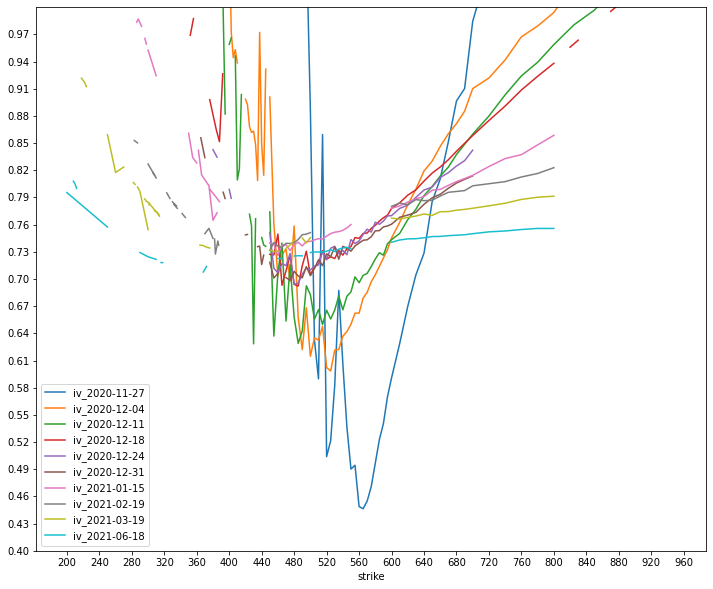

In [74]:
# find_best_call_to_buy('AAL', min_strike=10, max_strike=30)
find_best_call_to_buy('TSLA', min_iv=0.4, max_iv=1.0, min_strike=200, max_strike=1000)